# Figure B2: Sensitivity to sanction severity (F)

This notebook reproduces **Figure B2** in Appendix B of the paper  
*“Asynchronous Implementation of the Travel Rule and Transitional Risks in Crypto-Asset Regulation.”*

## Purpose
The analysis tests whether the main findings depend on the assumed severity of sanctions imposed upon detection.

The sanction level F is varied over a wide range to assess whether stronger or weaker penalties alter the relative effectiveness of synchronized versus asynchronous adoption.

## Output
The notebook generates `Figure_B2_F.png`, reporting the average number of successful illicit transactions during the transition period (t = 6–35).

Across all sanction levels, asynchronous adoption scenarios exhibit higher illicit activity than the synchronized benchmark.

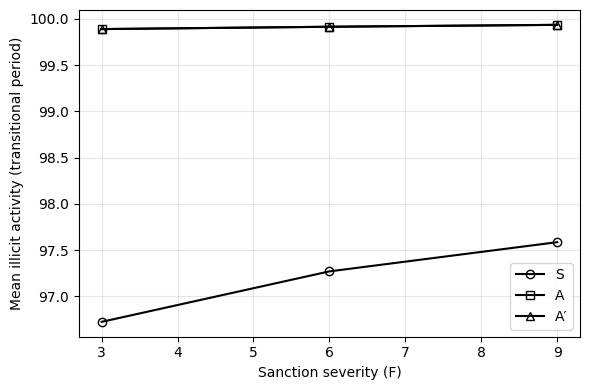

In [ ]:
# ============================================
# Appendix B - Figure B2
# Robustness to sanction severity (F)
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Scenario parameters
# ----------------------------
def scenario_params(scenario):
    if scenario == "S":
        Tj = np.array([6, 6, 6, 6, 6, 6])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "A":
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "Aprime":
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.015, 0.015])
    else:
        raise ValueError("Unknown scenario")
    return Tj, rho


# ----------------------------
# Core ABM (Y only, F variable)
# ----------------------------
def run_one(
    scenario,
    seed,
    *,
    F,
    lam=5,
    T=60,
    N=100,
):
    rng = np.random.default_rng(seed)

    Tj, rho = scenario_params(scenario)

    J = 6
    L = np.zeros(J)
    R = np.zeros(J)
    Y = np.zeros(T)

    for t in range(T):
        for j in range(J):
            if t >= Tj[j]:
                L[j] = 1
                R[j] = min(1.0, R[j] + rho[j])

        # sunrise gap
        s_gap = 1.0 - np.mean(L * R)

        pA = np.clip(0.18 - 0.4 * s_gap, 0, 1)
        pB = np.clip(0.08 - 0.5 * s_gap, 0, 1)
        pC = 0.02

        costA, costB, costC = pA * F + 0.2, pB * F + 0.05, pC * F + 0.8
        costs = np.array([costA, costB, costC])

        probs = np.exp(-lam * costs)
        probs /= probs.sum()

        choices = rng.choice([0, 1, 2], size=N, p=probs)
        caught = rng.random(N) < np.where(
            choices == 0, pA, np.where(choices == 1, pB, pC)
        )

        Y[t] = N - caught.sum()

    return Y


# ----------------------------
# Transitional mean Y
# ----------------------------
def transitional_mean_Y(
    scenario,
    *,
    F,
    Rruns,
    lam=5,
    t1=6,
    t2=35,
    seed0=20000,
):
    vals = []
    for r in range(Rruns):
        Y = run_one(
            scenario,
            seed=seed0 + r,
            F=F,
            lam=lam,
        )
        vals.append(Y[t1 : t2 + 1].mean())
    return np.mean(vals)


# ----------------------------
# Figure B2
# ----------------------------
def make_figure_B2(
    *,
    F_grid=(3, 6, 9),
    Rruns=120,
    savepath="Figure_B2_F.png",
):
    Y_S, Y_A, Y_Ap = [], [], []

    for F in F_grid:
        Y_S.append(transitional_mean_Y("S", F=F, Rruns=Rruns))
        Y_A.append(transitional_mean_Y("A", F=F, Rruns=Rruns))
        Y_Ap.append(transitional_mean_Y("Aprime", F=F, Rruns=Rruns))

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(
        F_grid, Y_S,
        marker="o",
        linestyle="-",
        color="black",
        markerfacecolor="none",
        markeredgecolor="black",
        label="S",
    )
    ax.plot(
        F_grid, Y_A,
        marker="s",
        linestyle="-",
        color="black",
        markerfacecolor="none",
        markeredgecolor="black",
        label="A",
    )
    ax.plot(
        F_grid, Y_Ap,
        marker="^",
        linestyle="-",
        color="black",
        markerfacecolor="none",
        markeredgecolor="black",
        label="A′",
    )

    ax.set_xlabel("Sanction severity (F)")
    ax.set_ylabel("Mean illicit activity (transitional period)")
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.show()


# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    make_figure_B2()
